Libraries imported successfully!
Manufacturing Production Modeling - Ready to Start
Dataset created with 1000 samples
Features: 10
Target variable: Production Orders

Dataset Statistics:
       raw_material_A  raw_material_B  raw_material_C  semi_product_X  \
count         1000.00         1000.00         1000.00         1000.00   
mean            50.29           30.71           20.07           99.53   
std             14.69            9.97            7.80           25.68   
min              1.38            0.60            0.24           26.76   
25%             40.29           23.94           14.82           81.56   
50%             50.38           30.63           20.00          100.00   
75%             59.72           37.29           25.29          116.67   
max            107.79           61.93           51.41          181.08   

       semi_product_Y  packaging_material  machine_capacity  labor_hours  \
count         1000.00             1000.00           1000.00      1000.00   
mea

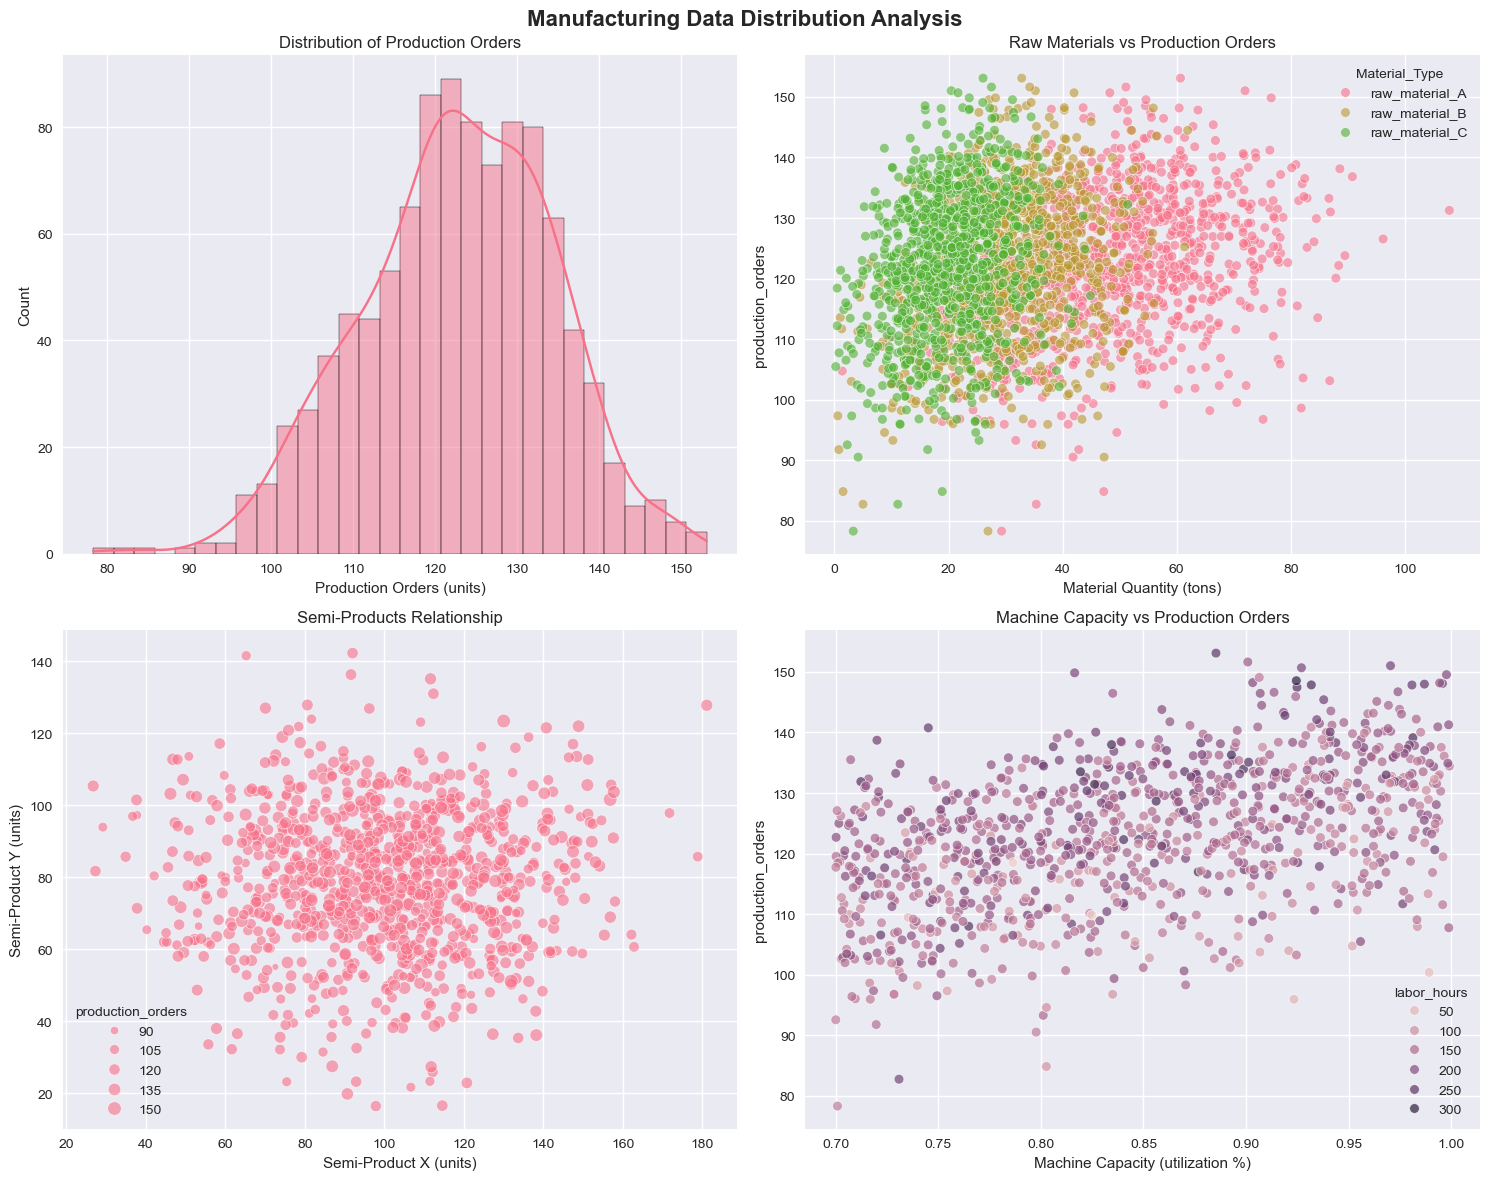

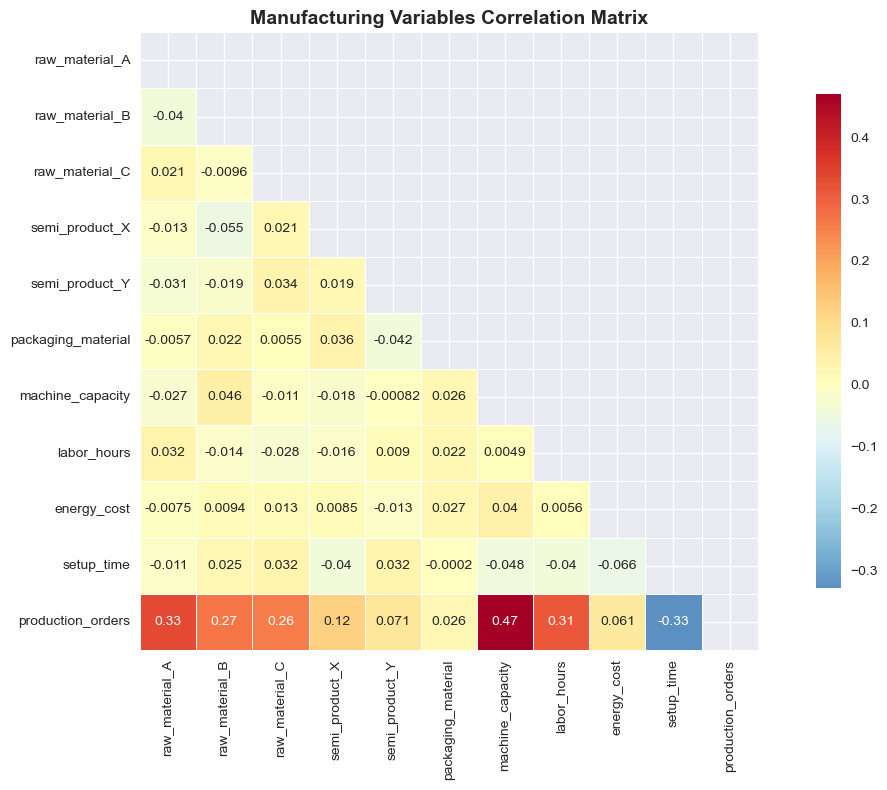


Top correlations with Production Orders:
machine_capacity: 0.470
raw_material_A: 0.333
setup_time: 0.329
labor_hours: 0.312
raw_material_B: 0.268
raw_material_C: 0.259
semi_product_X: 0.123
semi_product_Y: 0.071
energy_cost: 0.061
packaging_material: 0.026
Feature engineering completed!
Total features created: 19

New features: ['material_ratio_AB', 'material_ratio_BC', 'total_raw_materials', 'semi_product_ratio', 'total_semi_products', 'efficiency_score', 'material_bottleneck', 'semi_bottleneck', 'resource_intensity']
Training set: (800, 19)
Test set: (200, 19)

Training Gradient Boosting model...
Model training completed!

=== Model Performance ===
Training R²: 0.9957
Test R²: 0.8954
Training MSE: 0.5761
Test MSE: 13.2996
Training MAE: 0.5789
Test MAE: 2.8556


In [1]:
# ============================================================================
# MANUFACTURING PRODUCTION CAPACITY MODELING WITH GRADIENT BOOSTING
# Raw Material Constraints and Semi-Product Optimization
# ============================================================================

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("Manufacturing Production Modeling - Ready to Start")

# ============================================================================
# 1. GENERATE SYNTHETIC MANUFACTURING DATA
# ============================================================================

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic manufacturing data
n_samples = 1000

# Create manufacturing dataset
data = {
    'raw_material_A': np.random.normal(50, 15, n_samples),  # tons
    'raw_material_B': np.random.normal(30, 10, n_samples),  # tons
    'raw_material_C': np.random.normal(20, 8, n_samples),   # tons
    'semi_product_X': np.random.normal(100, 25, n_samples), # units
    'semi_product_Y': np.random.normal(80, 20, n_samples),  # units
    'packaging_material': np.random.normal(200, 50, n_samples), # units
    'machine_capacity': np.random.uniform(0.7, 1.0, n_samples), # utilization %
    'labor_hours': np.random.normal(160, 40, n_samples),    # hours
    'energy_cost': np.random.normal(1000, 200, n_samples),  # cost units
    'setup_time': np.random.uniform(2, 8, n_samples)       # hours
}

df = pd.DataFrame(data)

# Ensure non-negative values
df = df.abs()

# Calculate production capacity based on material constraints
# Complex formula considering multiple constraints
df['production_orders'] = (
    0.3 * np.minimum(df['raw_material_A'] * 2, 100) +
    0.25 * np.minimum(df['raw_material_B'] * 3, 90) +
    0.2 * np.minimum(df['raw_material_C'] * 4, 80) +
    0.15 * np.minimum(df['semi_product_X'] * 0.8, 80) +
    0.1 * np.minimum(df['semi_product_Y'] * 0.9, 72) +
    df['machine_capacity'] * 50 +
    (df['labor_hours'] / 10) * df['machine_capacity'] -
    df['setup_time'] * 2 +
    np.random.normal(0, 5, n_samples)  # Add some noise
)

# Ensure production orders are positive
df['production_orders'] = np.maximum(df['production_orders'], 0)

print(f"Dataset created with {len(df)} samples")
print(f"Features: {len(df.columns)-1}")
print(f"Target variable: Production Orders")

# Display basic statistics
print("\nDataset Statistics:")
print(df.describe().round(2))

# ============================================================================
# 2. EXPLORATORY DATA ANALYSIS WITH SEABORN
# ============================================================================

# Set up the plotting area
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Manufacturing Data Distribution Analysis', fontsize=16, fontweight='bold')

# 1. Distribution of production orders
sns.histplot(data=df, x='production_orders', bins=30, kde=True, ax=axes[0,0])
axes[0,0].set_title('Distribution of Production Orders')
axes[0,0].set_xlabel('Production Orders (units)')

# 2. Raw materials correlation with production
raw_materials = ['raw_material_A', 'raw_material_B', 'raw_material_C']
df_raw = df[raw_materials + ['production_orders']].melt(
    id_vars=['production_orders'], 
    var_name='Material_Type', 
    value_name='Quantity'
)
sns.scatterplot(data=df_raw, x='Quantity', y='production_orders', 
                hue='Material_Type', alpha=0.6, ax=axes[0,1])
axes[0,1].set_title('Raw Materials vs Production Orders')
axes[0,1].set_xlabel('Material Quantity (tons)')

# 3. Semi-products impact
sns.scatterplot(data=df, x='semi_product_X', y='semi_product_Y', 
                size='production_orders', alpha=0.6, ax=axes[1,0])
axes[1,0].set_title('Semi-Products Relationship')
axes[1,0].set_xlabel('Semi-Product X (units)')
axes[1,0].set_ylabel('Semi-Product Y (units)')

# 4. Machine capacity vs production
sns.scatterplot(data=df, x='machine_capacity', y='production_orders', 
                hue='labor_hours', alpha=0.7, ax=axes[1,1])
axes[1,1].set_title('Machine Capacity vs Production Orders')
axes[1,1].set_xlabel('Machine Capacity (utilization %)')

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Generate heatmap
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', 
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Manufacturing Variables Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print key correlations with production orders
prod_corr = correlation_matrix['production_orders'].abs().sort_values(ascending=False)
print("\nTop correlations with Production Orders:")
for var, corr in prod_corr.items():
    if var != 'production_orders':
        print(f"{var}: {corr:.3f}")

# ============================================================================
# 3. FEATURE ENGINEERING AND DATA PREPARATION
# ============================================================================

# Feature engineering for manufacturing constraints
df_features = df.copy()

# Calculate material ratios
df_features['material_ratio_AB'] = df_features['raw_material_A'] / (df_features['raw_material_B'] + 1e-6)
df_features['material_ratio_BC'] = df_features['raw_material_B'] / (df_features['raw_material_C'] + 1e-6)

# Total raw materials available
df_features['total_raw_materials'] = (df_features['raw_material_A'] + 
                                     df_features['raw_material_B'] + 
                                     df_features['raw_material_C'])

# Semi-product efficiency ratio
df_features['semi_product_ratio'] = df_features['semi_product_X'] / (df_features['semi_product_Y'] + 1e-6)
df_features['total_semi_products'] = df_features['semi_product_X'] + df_features['semi_product_Y']

# Manufacturing efficiency indicators
df_features['efficiency_score'] = (df_features['machine_capacity'] * df_features['labor_hours']) / \
                                 (df_features['setup_time'] + df_features['energy_cost']/1000)

# Bottleneck identification
df_features['material_bottleneck'] = df_features[['raw_material_A', 'raw_material_B', 'raw_material_C']].min(axis=1)
df_features['semi_bottleneck'] = df_features[['semi_product_X', 'semi_product_Y']].min(axis=1)

# Resource utilization per order
df_features['resource_intensity'] = (df_features['total_raw_materials'] + 
                                   df_features['total_semi_products']/10) / \
                                   (df_features['production_orders'] + 1e-6)

print("Feature engineering completed!")
print(f"Total features created: {len(df_features.columns)-1}")

# Display new features
new_features = [col for col in df_features.columns if col not in df.columns]
print(f"\nNew features: {new_features}")

# ============================================================================
# 4. GRADIENT BOOSTING MODEL IMPLEMENTATION
# ============================================================================

# Prepare features and target
X = df_features.drop('production_orders', axis=1)
y = df_features['production_orders']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features for better performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")

# Initialize Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    min_samples_split=20,
    min_samples_leaf=10,
    subsample=0.8,
    random_state=42
)

# Train the model
print("\nTraining Gradient Boosting model...")
gb_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = gb_model.predict(X_train_scaled)
y_test_pred = gb_model.predict(X_test_scaled)

print("Model training completed!")

# Calculate performance metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"\n=== Model Performance ===")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Training MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")
